# Automated Discovery of Burial Mounds (Tumuli)

This jupyter notebook uses the circular and elliptical hough transformation example from the scikit-image library to the automated detection of ancient burial mounds on Lidar scans. 
The work is inspired by discussions with a close friend, who is an archaeologist. He thinks that those burial mounds were used as waypoints for trade routes in the past. The image analyzed in this work is taken from https://www.denkmalpflege-bw.de/geschichte-auftrag-struktur/archaeologische-denkmalpflege/prospektion/

The basic idea is simple: As these burial mounds are round objects of similar size, it should be easy to extract them from Lidar images by applying the circular hough transformation. Applying this algorithm to a large number of scans should give us several candidates although the rate of false-positives could be potentially high.

This approach is seen as a first step to use better algorithms for this purpose. Object detection in images is a standard problem for packages like OpenCV which will be tested in the future.

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, io, color
from skimage.transform import hough_circle
from skimage.feature import peak_local_max, canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

Load the image. On the top left near the road crossing, one can see two large tumuli left of the road, and two smaller ones on the right. The most far right one is collapsed. This happens when the burial mound was opened before, e.g. by grave robbers.

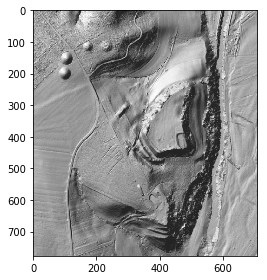

In [15]:
image = io.imread("input.jpg")[:,:,0] # or any NumPy array!
io.imshow(image)

In [16]:
image.shape

(777, 709)

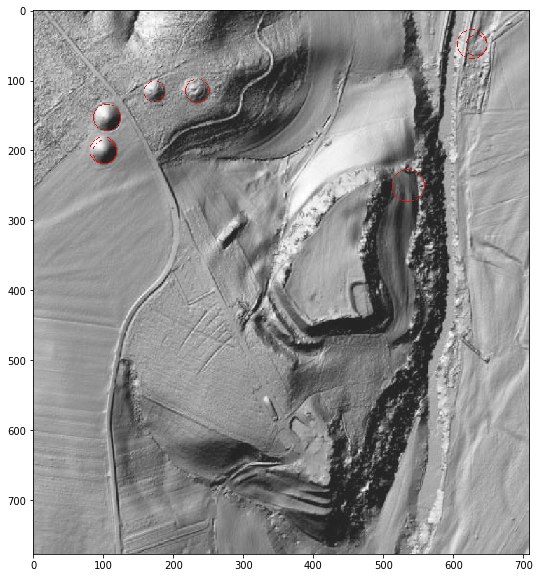

In [17]:
# Load picture and detect edges
#image = img_as_ubyte(data.coins()[0:95, 70:370])
edges = canny(image, sigma=3, low_threshold=10, high_threshold=50)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 2))
fig.set_size_inches(10,10)

# Detect two radii
hough_radii = np.arange(15, 30, 2)
hough_res = hough_circle(edges, hough_radii)

centers = []
accums = []
radii = []

for radius, h in zip(hough_radii, hough_res):
    # For each radius, extract two circles
    num_peaks = 2
    peaks = peak_local_max(h, num_peaks=num_peaks)
    centers.extend(peaks)
    accums.extend(h[peaks[:, 0], peaks[:, 1]])
    radii.extend([radius] * num_peaks)

# Draw the most prominent 5 circles
image = color.gray2rgb(image)
for idx in np.argsort(accums)[::-1][:8]:
    center_x, center_y = centers[idx]
    radius = radii[idx]
    cx, cy = circle_perimeter(center_y, center_x, radius)
    image[cy, cx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)


## Results
As we can see, the algorithm successfully marked the four burial mounds successfully! However, we also see some false positives on the right side of the image. 
The first results are quite encouraging, however there is a lot of room for improvement. 
As the size of the burial mounds can vary, we need some sort of scale-invariant algorithm to detect different sizes. It also remains to be checked if the hough transformation can find successfully identify collapsed mounds properly, although it works in this simple example.

In [18]:
io.imsave("discovered_mounds.png",image)